# Replicating XOR plots on Simpson data

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch.distributions as dist
import matplotlib.gridspec as gridspec
import wandb

In [24]:
 from source.tasks import DeepSurv

ModuleNotFoundError: No module named 'source'

## 1) Prep Simpsons Dataset

In [19]:
df = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_train.csv')
df.loc[:, 'x'] = df['feature0']
df.loc[:, 'y'] = df['feature1']
del df['feature0']
del df['feature1']

In [20]:
train_data = torch.tensor([df['x'].values, df['y'].values]).T
train_data.shape
train_labels = torch.tensor(df['time'].values)
train_labels.shape

torch.Size([7000])

In [ ]:
api

In [4]:
df_test = pd.read_csv('simpsons_valid.csv')
test_data = torch.tensor([df_test['x'].values, df_test['y'].values]).T
test_labels = torch.tensor(df_test['time'].values)
print(test_data.shape, test_labels.shape)

torch.Size([7000, 2]) torch.Size([7000])


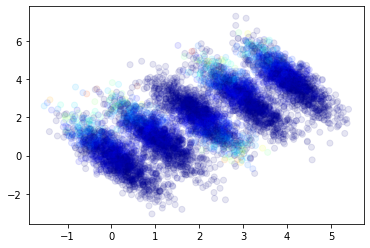

In [22]:
# Visualize dataset
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, alpha=0.1, cmap=cm.jet)
plt.show()

In [50]:
print(df['x'].min(), df['x'].max())
print(df['y'].min(), df['y'].max())
print(df['time'].min(), df['time'].max())

-1.735770586237808 5.43344128672322
-2.8675106708009963 7.209959077579023
0.0 2.4589214714720757


In [6]:
# set batch_size
batch_size = 100

# Prepare Dataloader for faster batch-wise training
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## 2) Build Model

In [67]:
class MLP(nn.Module):
    def __init__(self, hidden):
        super().__init__()
            
        self.fc1 = nn.Linear(2, hidden)
        self.fc2 = nn.Linear(hidden, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.relu(self.fc2(x))
    
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 5000)
        self.fc3 = nn.Linear(5000, 100)
        self.fc4 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.relu(self.fc4(x))
    
def train(model, data, crit, opt, dataset_size=7000, epochs=30, dev='cpu', batch_size=100):
    for e in range(epochs):
        print('Epoch {}/{}'.format(e+1, epochs))

        running_loss = 0.0
        i = 0
        for x_i, y_i in data:
            i += 1
            x_i, y_i = x_i.to(dev), y_i.to(dev)
            opt.zero_grad()
            output = model(x_i)
            loss = crit(output, y_i)
            loss.backward()
            opt.step()
            
            running_loss += loss.item()
        print('Loss: ' + format((running_loss/batch_size), '.4f'))
            
    print('Finished Training') 

def test():
    pass
        

In [35]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 100

model = MLP(hidden=10)
model = model.to(dev)

In [36]:
# Initialize weights between .5 and 1
for name, param in model.named_parameters():
    if param.requires_grad:
        torch.nn.init.normal_(param, mean=0.75, std=.1)

def look_at_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
            
# look_at_weights(model)

In [37]:
summary(model, (1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              30
            Linear-2                 [-1, 1, 1]              11
Total params: 41
Trainable params: 41
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## 3) Train model on data

In [38]:
# Push model on GPU
model = model.type(torch.cuda.DoubleTensor)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

# Train
train(model, data=train_loader, crit=criterion, opt=optimizer, dev=dev, batch_size=batch_size)

Epoch 1/30
Loss: 171.4885
Epoch 2/30
Loss: 1.2059
Epoch 3/30
Loss: 0.1563
Epoch 4/30
Loss: 0.1365
Epoch 5/30
Loss: 0.1361
Epoch 6/30
Loss: 0.1360
Epoch 7/30
Loss: 0.1360
Epoch 8/30
Loss: 0.1360
Epoch 9/30
Loss: 0.1360
Epoch 10/30
Loss: 0.1360
Epoch 11/30
Loss: 0.1360
Epoch 12/30
Loss: 0.1360
Epoch 13/30
Loss: 0.1360
Epoch 14/30
Loss: 0.1360
Epoch 15/30
Loss: 0.1360
Epoch 16/30
Loss: 0.1360
Epoch 17/30
Loss: 0.1360
Epoch 18/30
Loss: 0.1360
Epoch 19/30
Loss: 0.1360
Epoch 20/30
Loss: 0.1360
Epoch 21/30
Loss: 0.1360
Epoch 22/30
Loss: 0.1360
Epoch 23/30
Loss: 0.1360
Epoch 24/30
Loss: 0.1360
Epoch 25/30
Loss: 0.1360
Epoch 26/30
Loss: 0.1360
Epoch 27/30
Loss: 0.1360
Epoch 28/30
Loss: 0.1360
Epoch 29/30
Loss: 0.1360
Epoch 30/30
Loss: 0.1360
Finished Training


## 4) Visualize Attribution results for the 2D inputspace

In [39]:
from captum.attr import (
    NoiseTunnel,
    Saliency,
    IntegratedGradients,
    DeepLift,
    InputXGradient,
    GuidedBackprop,
    GuidedGradCam,
    Deconvolution,
    FeatureAblation,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling
)

In [40]:
# Get attribution results from Captum
methods = {
    'Saliency': Saliency(model),
    'Smoothgrad': NoiseTunnel(Saliency(model)),
    'IG': IntegratedGradients(model),
    'IxG': InputXGradient(model),
    'GuidedBackprop': GuidedBackprop(model),
    #'GuidedGradCAM': GuidedGradCam(model, model.fc1),
    #'DeepLift': DeepLift(model),  TODO: fix error; try skipping relu layer
    'Deconvolution': Deconvolution(model),
    'FeatureAblation': FeatureAblation(model),
    'Occlusion': Occlusion(model),
    #'FeaturePermutation': FeaturePermutation(model),
    #'ShapleyValueSampling': ShapleyValueSampling(model)
}

In [3]:
# Helper functions for sampling, calculating and plotting the attribution results
def create_steps(size=100):
    return np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))

def create_steps_simpson(size=100):
    return np.meshgrid(np.linspace(-10, 10, size), np.linspace(-10, 10, size))

def get_model_output(model, steps=100):
    x1, x2 = create_steps_simpson(steps)
    x1_flat, x2_flat = x1.reshape(len(x1)**2), x2.reshape(len(x2)**2)
    
    outs = np.empty([len(x1.reshape(len(x1)**2))])
    
    for c, data in enumerate(zip(x1_flat, x2_flat)):
        with torch.no_grad():
            xi1,xi2 = data
            x = torch.tensor([xi1,xi2], requires_grad=True)#.to(dev)
            
            # Workarounds..
            x = x.type(torch.cuda.FloatTensor)
            model = model.type(torch.cuda.FloatTensor)
#             x = x.to(dev)
#             x=x.cpu()
#             model=model.cpu()
#             model = model.type(torch.FloatTensor)
            
            out = model(x)#.double()
            outs[c] = out
    return outs, x1, x2

def get_attribution_output(method, steps=100, name=None):
    x1, x2 = create_steps_simpson(steps)
    x1_flat, x2_flat = x1.reshape(len(x1)**2), x2.reshape(len(x2)**2)
    
    # first outs dim is number of dims of attr
    outs = np.empty([2, len(x1.reshape(len(x1)**2))])
    
    for c, data in enumerate(zip(x1_flat, x2_flat)):
        with torch.no_grad():
            xi1,xi2 = data
            # Create sample of this iteration
            x = torch.tensor([[xi1,xi2]], requires_grad=True)#.to(dev)
            ## Workarounds
            x = x.type(torch.cuda.FloatTensor)
            # Attribute!
            if name == 'Occ':
                baseline = 0.5  
                attr = method.attribute(x, sliding_window_shapes=(1,), baselines=torch.tensor([baseline, baseline])[None].to(dev))
            elif name == 'IG':
                baseline = .5
                attr = method.attribute(x, baselines=baseline)
            else:
                attr = method.attribute(x)
            
            for dim in range(len(attr[0])): # take first and only batch -> attr[0]
                outs[dim, c] = attr[0, dim]
    return outs, x1, x2

def plot_contour(outs, x1, x2, title=''):
    if outs.ndim == 1:
        plt.figure(figsize=[6, 6])
        z = outs.reshape(int(np.sqrt(outs.shape)), int(np.sqrt(outs.shape)))
#         plt.contourf(x1, x2, z, cmap='seismic')
        plt.scatter(x1, x2, c=z, vmax=abs(z).max(), vmin=-abs(z).max(), cmap='seismic')
        plt.title('Output Visualization ' + title)
        plt.colorbar()
    else:
        plt.figure(figsize=[12, 6])
        for dim in range(outs.ndim):
            z = outs[dim].reshape(int(np.sqrt(outs[dim].shape)), int(np.sqrt(outs[dim].shape)))
            plt.subplot(int(np.floor(dim/3))+1, 2, dim+1)
#             plt.contourf(x1, x2, z, cmap='seismic')
            plt.scatter(x1, x2, c=z, vmax=abs(z).max(), vmin=-abs(z).max(), cmap='seismic')
            plt.title('Dimension ' + str(dim+1))
            plt.colorbar()
    plt.show() 

### Plot model output

In [46]:
# Set sampling rate
steps = 200

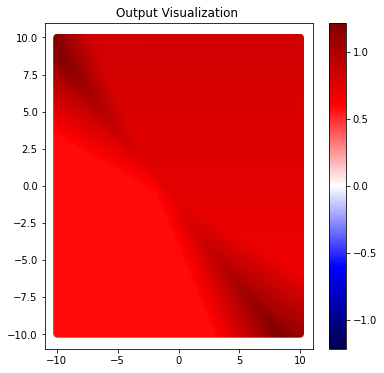

In [47]:
# Plot decision boundaries for model
plot_outputs, x1, x2 = get_model_output(model, steps=steps)
plot_contour(plot_outputs, x1, x2)

In [44]:
plot_outputs

array([0.73855561, 0.73855621, 0.73855674, ..., 0.7476781 , 0.7476787 ,
       0.74767935])

In [ ]:
# Check bigger model

In [72]:
mlp2 = MLP2()
mlp2 = mlp2.to(dev)

In [73]:
# Initialize weights between .5 and 1
# for name, param in mlp2.named_parameters():
#     if param.requires_grad:
#         torch.nn.init.normal_(param, mean=0.75, std=.1)

In [76]:
# Push model on GPU
mlp2 = mlp2.type(torch.cuda.DoubleTensor)

criterion = nn.MSELoss()
optimizer = optim.SGD(mlp2.parameters(), lr=1e-5, momentum=0.9)

# Train
train(mlp2, data=train_loader, crit=criterion, opt=optimizer, epochs=100, dev=dev, batch_size=batch_size)

Epoch 1/100
Loss: 0.1463
Epoch 2/100
Loss: 0.1457
Epoch 3/100
Loss: 0.1452
Epoch 4/100
Loss: 0.1444
Epoch 5/100
Loss: 0.1441
Epoch 6/100
Loss: 0.1435
Epoch 7/100
Loss: 0.1431
Epoch 8/100
Loss: 0.1428
Epoch 9/100
Loss: 0.1424
Epoch 10/100
Loss: 0.1421
Epoch 11/100
Loss: 0.1417
Epoch 12/100
Loss: 0.1414
Epoch 13/100
Loss: 0.1412
Epoch 14/100
Loss: 0.1410
Epoch 15/100
Loss: 0.1407
Epoch 16/100
Loss: 0.1405
Epoch 17/100
Loss: 0.1403
Epoch 18/100
Loss: 0.1401
Epoch 19/100
Loss: 0.1400
Epoch 20/100
Loss: 0.1399
Epoch 21/100
Loss: 0.1398
Epoch 22/100
Loss: 0.1397
Epoch 23/100
Loss: 0.1394
Epoch 24/100
Loss: 0.1393
Epoch 25/100
Loss: 0.1392
Epoch 26/100
Loss: 0.1391
Epoch 27/100
Loss: 0.1390
Epoch 28/100
Loss: 0.1389
Epoch 29/100
Loss: 0.1389
Epoch 30/100
Loss: 0.1388
Epoch 31/100
Loss: 0.1387
Epoch 32/100
Loss: 0.1387
Epoch 33/100
Loss: 0.1386
Epoch 34/100
Loss: 0.1385
Epoch 35/100
Loss: 0.1385
Epoch 36/100
Loss: 0.1385
Epoch 37/100
Loss: 0.1383
Epoch 38/100
Loss: 0.1384
Epoch 39/100
Loss: 0.

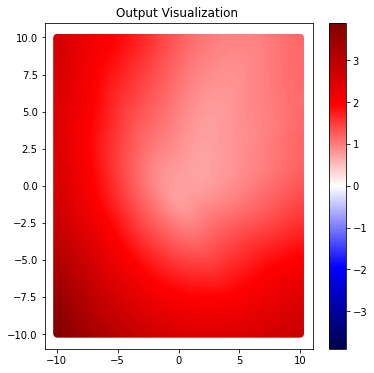

In [77]:
# Plot decision boundaries for model
plot_outputs, x1, x2 = get_model_output(mlp2, steps=steps)
plot_contour(plot_outputs, x1, x2)

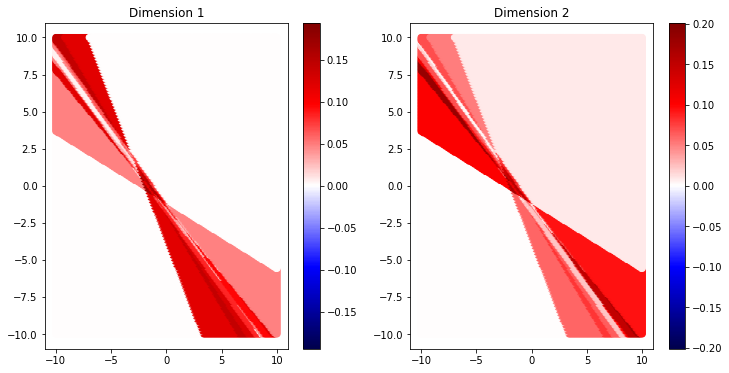

In [83]:
# Saliency
plot_outputs_sal, x1, x2 = get_attribution_output(methods['Saliency'], steps=steps)
plot_contour(plot_outputs_sal, x1, x2)

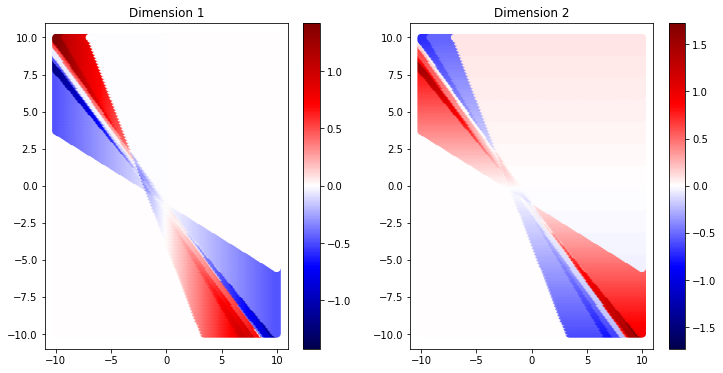

In [84]:
# Grad \times input
plot_outputs_IxG, x1, x2 = get_attribution_output(methods['IxG'], steps=steps)
plot_contour(plot_outputs_IxG, x1, x2)

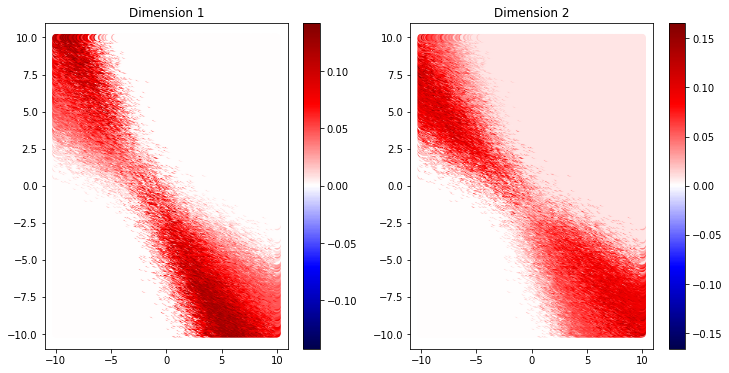

In [85]:
# Smoothgrad
plot_outputs_smooth, x1, x2 = get_attribution_output(methods['Smoothgrad'], steps=steps)
plot_contour(plot_outputs_smooth, x1, x2)

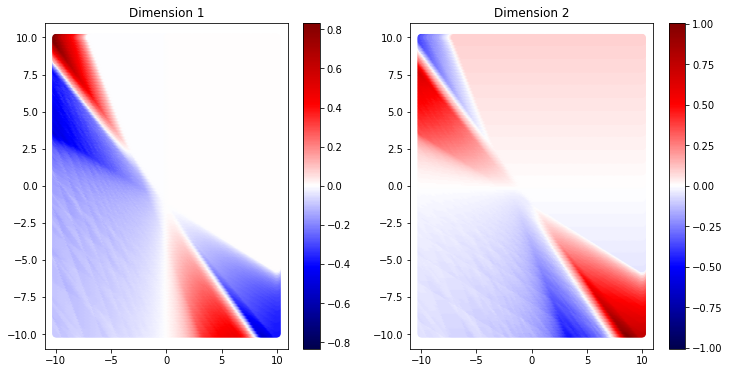

In [86]:
# IntGrad
plot_outputs_intgrad, x1, x2 = get_attribution_output(methods['IG'], steps=steps)
plot_contour(plot_outputs_intgrad, x1, x2)

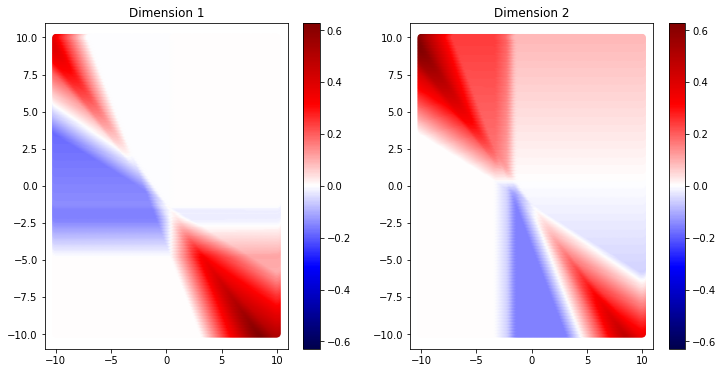

In [87]:
# Occlusion
plot_outputs_Occ, x1, x2 = get_attribution_output(methods['Occlusion'], steps=steps, name='Occ')
plot_contour(plot_outputs_Occ, x1, x2)

In [89]:
# Create input for plot
plot_list = {
    'Input': plot_outputs,
    'Saliency': plot_outputs_sal,
    'Smoothgrad': plot_outputs_smooth,
    'InputxGradient': plot_outputs_IxG,
    'IntGrad': plot_outputs_intgrad,
    'Occlusion': plot_outputs_Occ,
#     'IBA': plot_outputs_iba
}

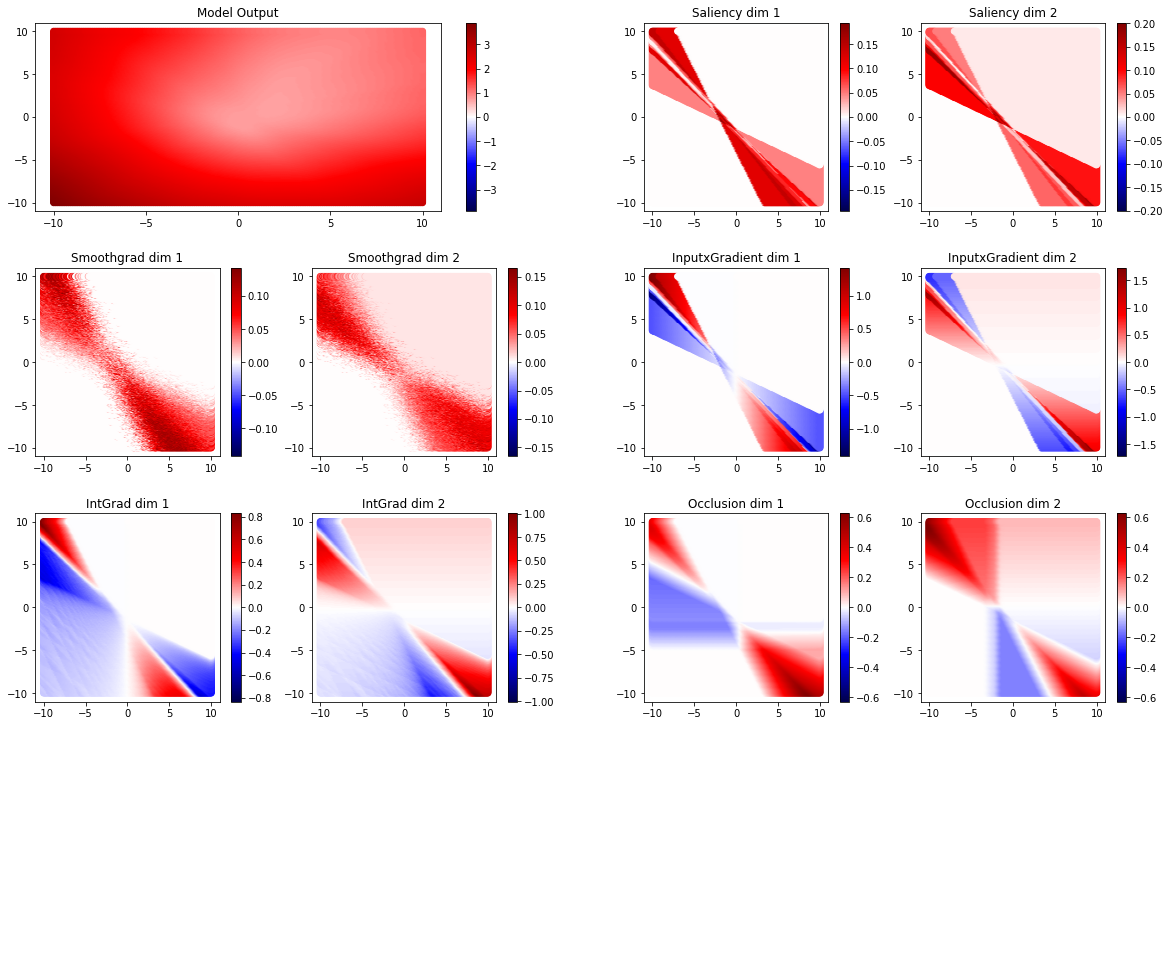

In [93]:
def xor_bigplot(plot_list, x1, x2):
    fig = plt.figure(figsize=(20, 17))
    outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.3)
    plt.box(on=None)
    plt.axis('off')

    for i, (name, output_i) in enumerate(plot_list.items()):
        inner = gridspec.GridSpecFromSubplotSpec(1, output_i.ndim,
                        subplot_spec=outer[i], wspace=0.2, hspace=0.3)
        
        for j in range(output_i.ndim):
            ax = plt.Subplot(fig, inner[j])
            if output_i.ndim == 1:
                z = output_i.reshape(int(np.sqrt(output_i.shape)), int(np.sqrt(output_i.shape)))
#                 im = ax.contourf(x1, x2, z, cmap='seismic', vmax=abs(z).max(), vmin=-abs(z).max())
                im = ax.scatter(x1, x2, c=z, vmax=abs(z).max(), vmin=-abs(z).max(), cmap='seismic')
                ax.set_title('Model Output')
                plt.colorbar(im, ax=ax)#, fraction=0.046, pad=0.04)
            else:
                z = output_i[j].reshape(int(np.sqrt(output_i[j].shape)), int(np.sqrt(output_i[j].shape)))
#                 im = ax.contourf(x1, x2, z, cmap='seismic', vmax=abs(z).max(), vmin=-(abs(z).max()), levels=)
                im = ax.scatter(x1, x2, c=z, vmax=abs(z).max(), vmin=-abs(z).max(), cmap='seismic')
                ax.set_title(name + ' dim ' + str(j+1))
                plt.colorbar(im, ax=ax)
            
            ax.set_xticks([-10.0, -5.0,0.0,5.0,10.0])
            ax.set_yticks([-10.0, -5.0,0.0,5.0,10.0])
            fig.add_subplot(ax)
    
    fig.show()
#     plt.savefig('xor_bigplot_scatter.jpg')

xor_bigplot(plot_list, x1, x2)

In [18]:
#XOR to check:
def sample_gaussian(x, std=.2):
    x_s = x.clone()
    for dim in range(len(x)):
        x_dist = dist.normal.Normal(x[dim], torch.tensor([std]))
        x_s[dim] = x_dist.sample()
    return x_s

def sample_dataset(size, x):
    global x_train, y_train, x_test, y_test
    x_train = x_test = torch.zeros((size, 2))
    y_train = y_test = torch.zeros((size, 1))
    
    index = -1
    for i in range(int(size / 4)):
        for j in range(4):
            index+=1
            x_train[index] = sample_gaussian(x[j])
            x_test[index] = sample_gaussian(x[j])
            y_train[index] = 0 if j == 0 or j == 3 else 1
            y_test[index] = 0 if j == 0 or j == 3 else 1

In [19]:
# Prepare dataset
x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)

# y_and = torch.tensor([a & b for a, b in x.type(torch.LongTensor)])
# y_or = torch.tensor([a | b for a, b in x.type(torch.LongTensor)])
y_xor = torch.tensor([a ^ b for a, b in x.type(torch.LongTensor)])

# y_and = y_and.type(torch.FloatTensor)
# y_or = y_or.type(torch.FloatTensor)
y_xor = y_xor.type(torch.FloatTensor)

sample_dataset(7000, x)

torch.Size([7000, 2])
torch.Size([7000, 1])


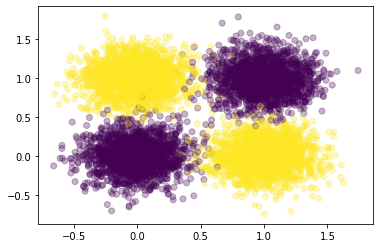

In [20]:
# Plot dataset
print(x_train.shape)
print(y_train.shape)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.squeeze(), alpha=0.3)
plt.show()

In [21]:
# Prepare Dataloader for faster batch-wise training
train_dataset_xor = TensorDataset(x_train, y_train)
test_dataset_xor = TensorDataset(x_test, y_test)

train_loader_xor = torch.utils.data.DataLoader(train_dataset_xor,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader_xor = torch.utils.data.DataLoader(test_dataset_xor,
                                          batch_size=batch_size,
                                          shuffle=False)

In [30]:
# xor_model = MLP(1000).to(dev)
xor_model = MLP2().to(dev)
criterion = nn.MSELoss()
optimizer = optim.SGD(xor_model.parameters(), lr=1e-3, momentum=0.9)

# Initialize weights between .5 and 1
# for name, param in xor_model.named_parameters():
#     if param.requires_grad:
#         torch.nn.init.normal_(param, mean=0.75, std=.15)

In [31]:
# look_at_weights(xor_model)

In [32]:
train(xor_model, data=train_loader_xor, crit=criterion, opt=optimizer, dev=dev, batch_size=batch_size)

Epoch 1/30
Loss: 0.1886
Epoch 2/30
Loss: 0.1654
Epoch 3/30
Loss: 0.1558
Epoch 4/30
Loss: 0.1443
Epoch 5/30
Loss: 0.1301
Epoch 6/30
Loss: 0.1128
Epoch 7/30
Loss: 0.0924
Epoch 8/30
Loss: 0.0708
Epoch 9/30
Loss: 0.0515
Epoch 10/30
Loss: 0.0376
Epoch 11/30
Loss: 0.0292
Epoch 12/30
Loss: 0.0244
Epoch 13/30
Loss: 0.0216
Epoch 14/30
Loss: 0.0197
Epoch 15/30
Loss: 0.0183
Epoch 16/30
Loss: 0.0172
Epoch 17/30
Loss: 0.0164
Epoch 18/30
Loss: 0.0157
Epoch 19/30
Loss: 0.0152
Epoch 20/30
Loss: 0.0148
Epoch 21/30
Loss: 0.0144
Epoch 22/30
Loss: 0.0141
Epoch 23/30
Loss: 0.0138
Epoch 24/30
Loss: 0.0136
Epoch 25/30
Loss: 0.0133
Epoch 26/30
Loss: 0.0131
Epoch 27/30
Loss: 0.0130
Epoch 28/30
Loss: 0.0128
Epoch 29/30
Loss: 0.0126
Epoch 30/30
Loss: 0.0125
Finished Training


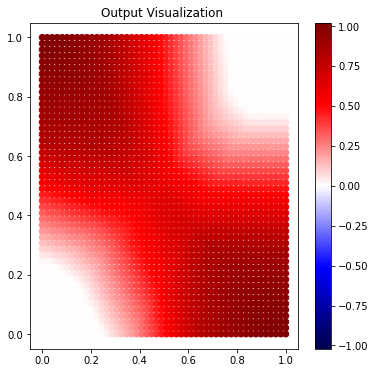

In [33]:
# Plot decision boundaries for model
plot_outputs, x1, x2 = get_model_output(xor_model, steps=50)
plot_contour(plot_outputs, x1, x2)